# Scalable Bayesian Modeling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/symeneses/SBM/blob/main/notebooks/tennis.ipynb)

In [ ]:
# Execute only if executing in Google Colab
# !rm -r ./src
# !rm -r ./data
# !git clone https://github.com/symeneses/SBM
# !mv ./SBM/src ./src
# !mv ./SBM/data ./data
# !rm -r ./SBM
# !pip install --upgrade pip
# !pip install --upgrade numpyro==0.11.0 pymc==5.0.2 blackjax==0.9.6 seaborn

This use case is based on the Blog Post: [MCMC for big datasets](https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html](https://martiningram.github.io/mcmc-comparison/)).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

cores = os.cpu_count()
os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={cores}'
root_path = os.path.abspath(os.pardir)
if root_path not in sys.path:
    sys.path.append(root_path)

## Importing the needed libraries

In [2]:
import pandas as pd
import numpy as np
import numpyro
import pymc as pm

from src.data import data_generator
from src.handler import Handler
from src.diagnostics import convergency_validator, dist_validator
from src.plots import plot_ess_ps, plot_monitor

RANDOM_SEED = 8957


/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Getting the data

Create a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the variables to be used to define the model.

✍🏽 User input required.

In [3]:
# Code to generate the data, name the final results as data
data = pd.read_csv("https://drive.google.com/uc?id=1KtkXe3_orIGCgP-_XE7tQdYWfqPzFTTF",
                   usecols=["tourney_date", "winner_name", "loser_name"],
                   parse_dates=['tourney_date'])
data["year"] = data["tourney_date"].dt.year

## Defining the model

In the following cells, write the code for the models you want to compare. To make comparing the models and results easier, use the same name of variables in each version of the model.

**For models in PyMC:** Create an annotated function, as in the example, that returns a `pm.model.Model`.

**For models in Numpyro:** Use the same variable names of the `DataFrame` `data` for the arguments of the function model. These arguments should contain only columns present in `data`.

✍🏽 User input required.

In [4]:

def pymc_model_gen(data: pd.DataFrame) -> pm.model.Model:
    _, players_map = (pd.concat([data["winner_name"], data["loser_name"]])).factorize()
    players = players_map.to_list()
    winners_codes = data["winner_name"].apply(lambda x: players.index(x)).values
    losers_codes = data["loser_name"].apply(lambda x: players.index(x)).values
    coords = {"players": np.arange(0, len(players))}
    with pm.Model(coords=coords) as pymc_model:
        # Your model here
        player_sd = pm.HalfNormal("player_sd", sigma=1.0)
        player_skills_raw = pm.Normal(
            "player_skills_raw", 0.0, sigma=1.0, dims="players")

        player_skills = pm.Deterministic("player_skills", player_skills_raw * player_sd)
        logit_skills = player_skills[winners_codes] - player_skills[losers_codes]

        lik = pm.Bernoulli(
            "win_lik", logit_p=logit_skills, observed=np.ones(winners_codes.shape[0])
        )
    return pymc_model

In [5]:
import numpyro.distributions as dist
from numpyro.infer import NUTS


def model(winner_name, loser_name):
    _, players_map = (pd.concat([winner_name, loser_name])).factorize()
    players = players_map.to_list()
    winners_codes = winner_name.apply(lambda x: players.index(x)).values
    losers_codes = loser_name.apply(lambda x: players.index(x)).values

    player_sd = numpyro.sample("player_sd", dist.HalfNormal(1.0))
    with numpyro.plate("players", len(players)):
        player_skills_raw = numpyro.sample("player_skills_raw", dist.Normal(0.0, 1.0))

    player_skills = numpyro.deterministic("player_skills", player_skills_raw * player_sd)
    logit_skills = player_skills[winners_codes] - player_skills[losers_codes]

    lik = numpyro.sample("win_lik", 
                         dist.BernoulliLogits(logit_skills),
                         obs=np.ones(winners_codes.shape[0]))

numpyro_kernel = NUTS(model)

## Inference
Here, we will create create valid [InferenceData](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.html) objects and a set of metrics to measure performance for the selected models, data sizes and samplers.

In [6]:
data.shape

(169073, 4)

### Creating multiple data sizes

To have a benchmark using different data sizes, we will use the function `data_generator` which will use the original dataset to generate datasets with the given `sizes` or filtering the original data in the parameter `filters`. You can also add Gaussian noise to selected variables using the parameter `include_noise`.

✍🏽 User input required.

In [7]:
data_sizes = []
include_noise = []
years = [2020, 2019, 2015, 2010, 2000, 1990, 1980, 1968]
filters = [f"year >= {y}" for y in years]
datasets = data_generator(data, filters=filters)
# If you want to work only with the original data, use this instead
# datasets = {"original_size": data}

In [8]:
data_sizes = [int(k) for k in datasets.keys()]
data_sizes

[6744, 9215, 19551, 32337, 60363, 93549, 126960, 169073]

### Sampling

⚠️ You should at least use 2 chains to be able to calculate correctly the diagnostics.

✍🏽 User input required.

In [9]:
# Use the following path if working in Google Colab
# output_path = "data/results"
output_path = "../data/results"
models = {"pymc": pymc_model_gen, "numpyro": numpyro_kernel}
pymc_samplers = ["default", "numpyro", "blackjax"]
draws = 2000
tune = 2000
# It's recommended to use between 2 and 4 chains
chains = 2

# sampling all models
handler = Handler(models, datasets, pymc_samplers, output_path)
infer_data, results = handler.execute(draws, tune, chains, RANDOM_SEED)


> Getting samples using libray pymc:

>> Getting samples for data with size 6744

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.575669
Sampling...
Sampling time =  0:00:18.611258
Transforming variables...
Transformation time =  0:00:00.119879

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.416332
Sampling...
Sampling time =  0:00:07.339884
Transforming variables...
Transformation time =  0:00:12.763354

>> Getting samples for data with size 9215

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.463714
Sampling...
Sampling time =  0:00:23.301053
Transforming variables...
Transformation time =  0:00:00.081346

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.457260
Sampling...
Sampling time =  0:00:07.612417
Transforming variables...
Transformation time =  0:00:16.677550

>> Getting samples for data with size 19551

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.528060
Sampling...
Sampling time =  0:00:48.320074
Transforming variables...
Transformation time =  0:00:00.082378

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.446271
Sampling...
Sampling time =  0:00:07.803320
Transforming variables...
Transformation time =  0:00:39.163036

>> Getting samples for data with size 32337

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 167 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.479910
Sampling...
Sampling time =  0:01:23.720103
Transforming variables...
Transformation time =  0:00:00.085146

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.466343
Sampling...
Sampling time =  0:00:07.625777
Transforming variables...
Transformation time =  0:01:13.345419

>> Getting samples for data with size 60363

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 300 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.428395
Sampling...
Sampling time =  0:02:50.502136
Transforming variables...
Transformation time =  0:00:00.090354

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.469506
Sampling...
Sampling time =  0:00:07.720800
Transforming variables...
Transformation time =  0:02:28.970998

>> Getting samples for data with size 93549

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 471 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.438509
Sampling...
Sampling time =  0:06:06.303316
Transforming variables...
Transformation time =  0:00:00.092036

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.420329
Sampling...
Sampling time =  0:00:07.123491
Transforming variables...
Transformation time =  0:03:03.506126

>> Getting samples for data with size 126960

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 649 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.456918
Sampling...
Sampling time =  0:05:58.195011
Transforming variables...
Transformation time =  0:00:00.094503

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.517456
Sampling...
Sampling time =  0:00:07.349567
Transforming variables...
Transformation time =  0:04:38.940715

>> Getting samples for data with size 169073

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1277 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.463156
Sampling...
Sampling time =  0:08:07.334990
Transforming variables...
Transformation time =  0:00:00.104611

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.457948
Sampling...
Sampling time =  0:00:07.208030
Transforming variables...
Transformation time =  0:06:43.145367

> Getting samples using libray numpyro:

>> Getting samples for data with size 6744


Running chain 1: 100%|██████████| 4000/4000 [00:16<00:00, 237.58it/s]



>> Getting samples for data with size 9215


Running chain 1: 100%|██████████| 4000/4000 [00:21<00:00, 188.82it/s]



>> Getting samples for data with size 19551


Running chain 1: 100%|██████████| 4000/4000 [00:41<00:00, 96.75it/s] 



>> Getting samples for data with size 32337


Running chain 1: 100%|██████████| 4000/4000 [01:06<00:00, 60.07it/s]



>> Getting samples for data with size 60363


Running chain 1: 100%|██████████| 4000/4000 [02:19<00:00, 28.61it/s]



>> Getting samples for data with size 93549


Running chain 1: 100%|██████████| 4000/4000 [03:17<00:00, 20.22it/s]



>> Getting samples for data with size 126960


Running chain 1: 100%|██████████| 4000/4000 [04:50<00:00, 13.79it/s]



>> Getting samples for data with size 169073


Running chain 1: 100%|██████████| 4000/4000 [07:26<00:00,  8.95it/s]


## Check Convergency

After sampling, the function `convergency_validator` will help you know if the models have converged. This function use the [rank normalized splitR-hat](https://python.arviz.org/en/latest/api/generated/arviz.rhat.html).

An $\hat R$ > 1.05 indicates convergence failures. In this case, the results of the next step `Validate Results` **can't be considered** as they assumed the MCMC has converged. 

In [20]:
convergency_validator(infer_data)

Convergency test using R-hat:
> pymc_default_6744       : 1.01 ✅
> pymc_numpyro_6744       : 1.00 ✅
> pymc_blackjax_6744      : 1.01 ✅
> pymc_default_9215       : 1.01 ✅
> pymc_numpyro_9215       : 1.01 ✅
> pymc_blackjax_9215      : 1.01 ✅
> pymc_default_19551      : 1.01 ✅
> pymc_numpyro_19551      : 1.01 ✅
> pymc_blackjax_19551     : 1.01 ✅
> pymc_default_32337      : 1.01 ✅
> pymc_numpyro_32337      : 1.01 ✅
> pymc_blackjax_32337     : 1.01 ✅
> pymc_default_60363      : 1.01 ✅
> pymc_numpyro_60363      : 1.01 ✅
> pymc_blackjax_60363     : 1.01 ✅
> pymc_default_93549      : 1.01 ✅
> pymc_numpyro_93549      : 1.01 ✅
> pymc_blackjax_93549     : 1.01 ✅
> pymc_default_126960     : 1.01 ✅
> pymc_numpyro_126960     : 1.01 ✅
> pymc_blackjax_126960    : 1.01 ✅
> pymc_default_169073     : 1.01 ✅
> pymc_numpyro_169073     : 1.01 ✅
> pymc_blackjax_169073    : 1.01 ✅
> numpyro_default_6744    : 1.01 ✅
> numpyro_default_9215    : 1.01 ✅
> numpyro_default_19551   : 1.01 ✅
> numpyro_default_32337  

## Validate results 

To check that the models are sampling from the same distributions. The function `dist_validator` will estimate the ranges of the mean for each variable using the [MCSE](https://python.arviz.org/en/latest/api/generated/arviz.mcse.html) of one of the models as reference. You can either give a `seed` to choose a model randomly or give the key `ref_key` of a selected model. The reference model will be compared only with others using the same sample size.

The percentages displayed indicate how many variables are within the calculated range using ±3 sigma. The values should be in theory greater or equal to `95%` following a weaker [three-sigma rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

In [11]:
results_val, summaries = dist_validator(infer_data, ref_key="pymc_numpyro_6744")

Percentage of variables with the expected mean using MCSE:
> pymc_default_6744       :  97.02% using as a reference pymc_numpyro_6744        ✅
> pymc_numpyro_6744       : 100.00% using as a reference pymc_numpyro_6744        ✅
> pymc_blackjax_6744      :  97.14% using as a reference pymc_numpyro_6744        ✅
> pymc_default_9215       :  97.24% using as a reference pymc_numpyro_9215        ✅
> pymc_numpyro_9215       : 100.00% using as a reference pymc_numpyro_9215        ✅
> pymc_blackjax_9215      :  98.30% using as a reference pymc_numpyro_9215        ✅
> pymc_default_19551      :  96.54% using as a reference pymc_numpyro_19551       ✅
> pymc_numpyro_19551      : 100.00% using as a reference pymc_numpyro_19551       ✅
> pymc_blackjax_19551     :  95.61% using as a reference pymc_numpyro_19551       ✅
> pymc_default_32337      :  95.24% using as a reference pymc_numpyro_32337       ✅
> pymc_numpyro_32337      : 100.00% using as a reference pymc_numpyro_32337       ✅
> pymc_blackjax_3

## Comparison

### Resources metrics

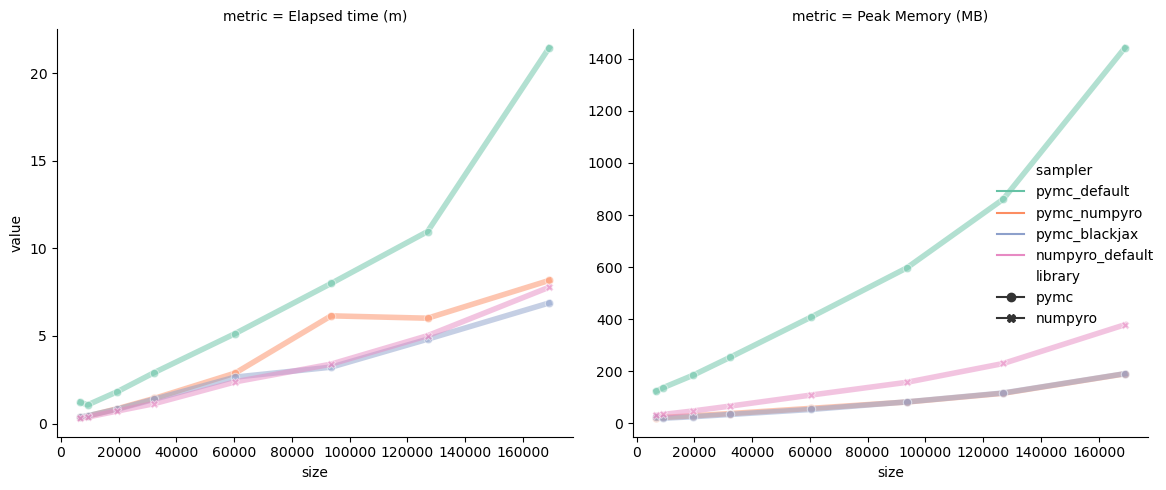

In [12]:
plot_monitor(results)

### ESS

To determine the sampler performance, we use the **Effective Sample Size** ([ESS](https://python.arviz.org/en/latest/api/generated/arviz.ess.html])) calculated per second.

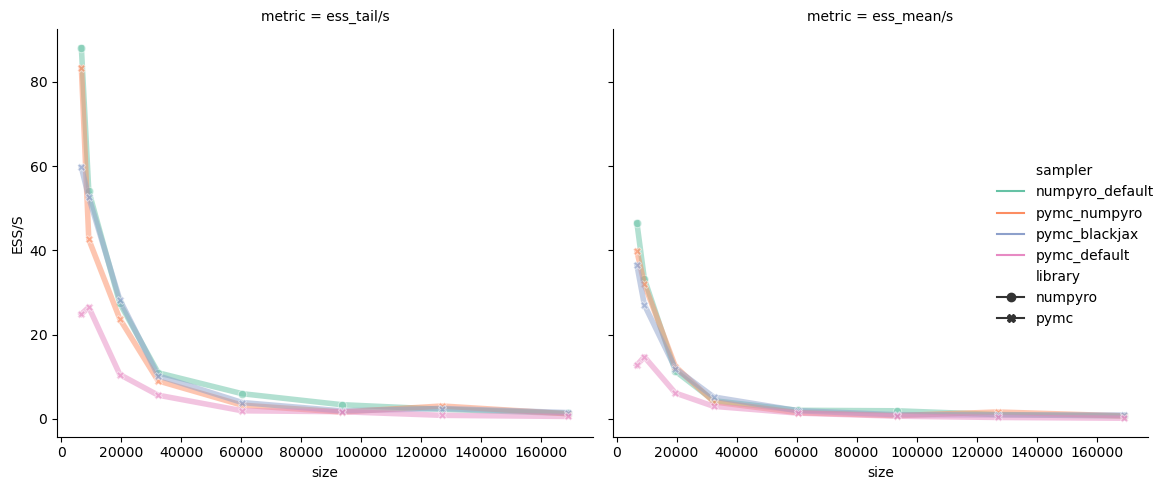

In [13]:
plot_ess_ps(results, summaries, data_sizes=data_sizes)

Using 'ESS per Second' previously calculated


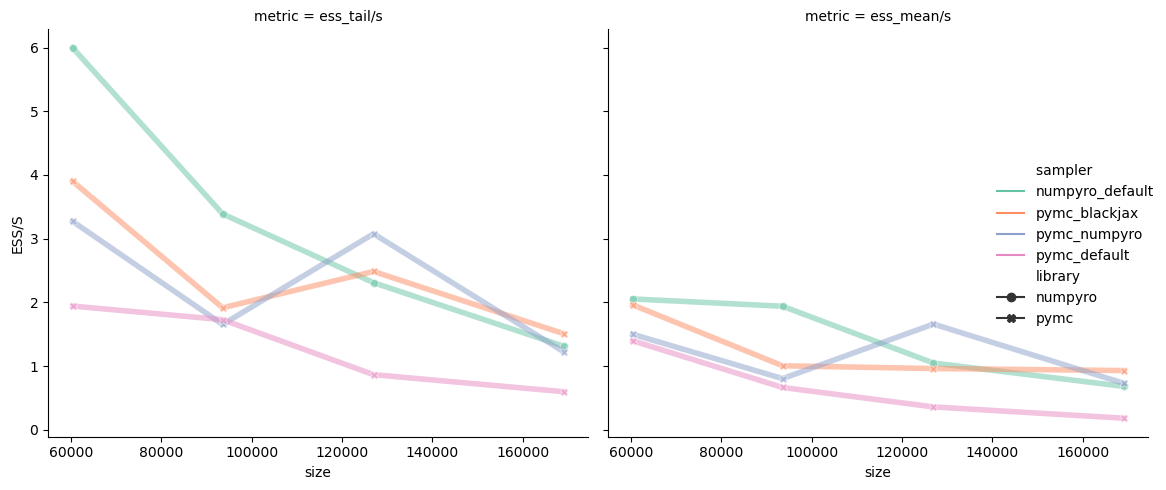

In [14]:
plot_ess_ps(results, summaries, data_sizes=data_sizes[-4:])

Using 'ESS per Second' previously calculated


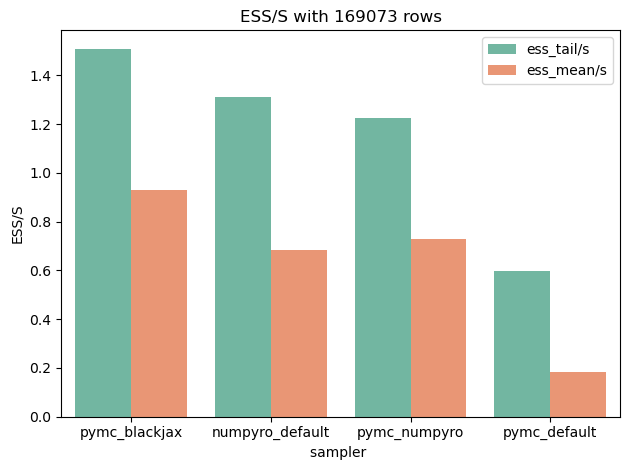

In [15]:
plot_ess_ps(results, summaries, data_sizes=[max(data_sizes)])

Let's rank the best across all data sizes:

In [16]:
summary = results.drop(columns=["current_memory", "peak_memory"])
summary["rank"] = summary.sort_values(["size", "ess_mean/s"], ascending=[True, False]) \
            .groupby(['size']) \
            .cumcount() + 1
summary.sort_values(["size", "rank"])

,library,sampler,size,elapsed_time,Peak Memory (MB),Elapsed time (m),ess_mean/s,ess_tail/s,rank
numpyro_default_6744,numpyro,default,6744.0,18.516138,30.602727,0.308602,46.511912,88.085321,1
pymc_numpyro_6744,pymc,numpyro,6744.0,21.418637,22.067568,0.356977,39.835962,83.385325,2
pymc_blackjax_6744,pymc,blackjax,6744.0,22.842896,23.718265,0.380715,36.495372,59.712217,3
pymc_default_6744,pymc,default,6744.0,72.854289,123.292656,1.214238,12.785507,24.899015,4
numpyro_default_9215,numpyro,default,9215.0,22.478361,34.070506,0.374639,33.292507,54.096470,1
pymc_numpyro_9215,pymc,numpyro,9215.0,25.901371,22.610729,0.431690,31.992863,42.623227,2
pymc_blackjax_9215,pymc,blackjax,9215.0,26.832395,19.443444,0.447207,27.115284,52.585691,3
pymc_default_9215,pymc,default,9215.0,64.050181,136.990686,1.067503,14.742722,26.526077,4
pymc_numpyro_19551,pymc,numpyro,19551.0,50.986790,28.465453,0.849780,12.439850,23.731637,1
pymc_blackjax_19551,pymc,blackjax,19551.0,49.493801,25.241754,0.824897,11.975500,28.306575,2


Let's see the best options in each data size:

In [17]:
summary.query("rank == 1").sort_values("size")

,library,sampler,size,elapsed_time,Peak Memory (MB),Elapsed time (m),ess_mean/s,ess_tail/s,rank
numpyro_default_6744,numpyro,default,6744.0,18.516138,30.602727,0.308602,46.511912,88.085321,1
numpyro_default_9215,numpyro,default,9215.0,22.478361,34.070506,0.374639,33.292507,54.096470,1
pymc_numpyro_19551,pymc,numpyro,19551.0,50.986790,28.465453,0.849780,12.439850,23.731637,1
pymc_blackjax_32337,pymc,blackjax,32337.0,83.523002,33.838134,1.392050,5.217473,10.236701,1
numpyro_default_60363,numpyro,default,60363.0,142.956207,108.334430,2.382603,2.054007,5.994843,1
numpyro_default_93549,numpyro,default,93549.0,203.594136,157.353861,3.393236,1.939466,3.389096,1
pymc_numpyro_126960,pymc,numpyro,126960.0,360.804403,115.318214,6.013407,1.659478,3.076459,1
pymc_blackjax_169073,pymc,blackjax,169073.0,412.925771,190.496933,6.882096,0.930046,1.508746,1


## Results 

Let's visualize the tennis player skill estimates, as done in the original post. See *Addendum 1*.

In [18]:
key = "pymc_blackjax_169073"
_, players_map = (pd.concat([data["winner_name"], data["loser_name"]])).factorize()
mean_skill = infer_data["pymc_blackjax_169073"].posterior['player_skills'].mean(dim=('chain', 'draw'))
sd_skill = infer_data["pymc_blackjax_169073"].posterior['player_skills'].std(dim=('chain', 'draw'))
tennis = pd.DataFrame({'mean_skill': mean_skill, 'sd_skill': sd_skill}, index=players_map) \
    .       sort_values('mean_skill', ascending=False)

In [19]:
tennis.head(20)

,mean_skill,sd_skill
Novak Djokovic,3.596984,0.091834
Rafael Nadal,3.456043,0.086376
Bjorn Borg,3.417285,0.105153
Roger Federer,3.377035,0.077224
Ivan Lendl,3.354090,0.083736
Jimmy Connors,3.331115,0.074757
John McEnroe,3.327619,0.090356
Rod Laver,3.296383,0.102233
Pete Sampras,3.012004,0.085432
Boris Becker,2.934064,0.089372
